In [1]:
import pandas as pd
import numpy as np
import joblib

In [2]:
df = pd.read_csv("../data/processed/2023_pace_laps_with_delta_phase.csv")

In [4]:
model = joblib.load(
    "../models/lap_delta_random_forest_prelap_phase.pkl"
)

In [5]:
FEATURES = [
    "TyreLife",
    "TyreLifeSquared",
    "LapInStint",
    "LapNumber",
    "Stint",
    "Compound_encoded",
    "Driver_encoded",
    "Team_encoded",
    "FuelProxy",
    "RaceProgress",
]

In [6]:
race = "Bahrain Grand Prix"
driver = "VER"
pit_loss_seconds = 22.0

race_df = df[
    (df["RaceName"] == race) &
    (df["Driver"] == driver)
].sort_values("LapNumber")

max_lap = race_df["LapNumber"].max()

In [7]:
def predict_lap_delta(row):
    X = row[FEATURES].values.reshape(1, -1)
    return model.predict(X)[0]

In [8]:
def simulate_race(race_df, pit_lap):
    total_delta = 0.0

    for _, row in race_df.iterrows():

        if row["LapNumber"] < pit_lap:
            total_delta += predict_lap_delta(row)

        elif row["LapNumber"] == pit_lap:
            total_delta += predict_lap_delta(row) + pit_loss_seconds

        else:
            new_row = row.copy()
            new_row["TyreLife"] = row["LapNumber"] - pit_lap + 1
            new_row["TyreLifeSquared"] = new_row["TyreLife"] ** 2
            new_row["LapInStint"] = new_row["TyreLife"]
            total_delta += predict_lap_delta(new_row)

    return total_delta


In [10]:
results = []

# Ensure max_lap is an integer
max_lap_int = int(race_df["LapNumber"].dropna().max())

# Define realistic pit window
start_lap = 10
end_lap = max_lap_int - 10

for pit_lap in range(start_lap, end_lap + 1):
    race_delta = simulate_race(race_df, pit_lap)
    results.append({
        "PitLap": pit_lap,
        "TotalLapDelta": race_delta
    })

results_df = pd.DataFrame(results)


C:\Users\kulka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kulka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kulka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kulka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\kulka\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have

In [11]:
optimal = results_df.loc[
    results_df["TotalLapDelta"].idxmin()
]

optimal

PitLap           42.000000
TotalLapDelta   -62.423254
Name: 32, dtype: float64

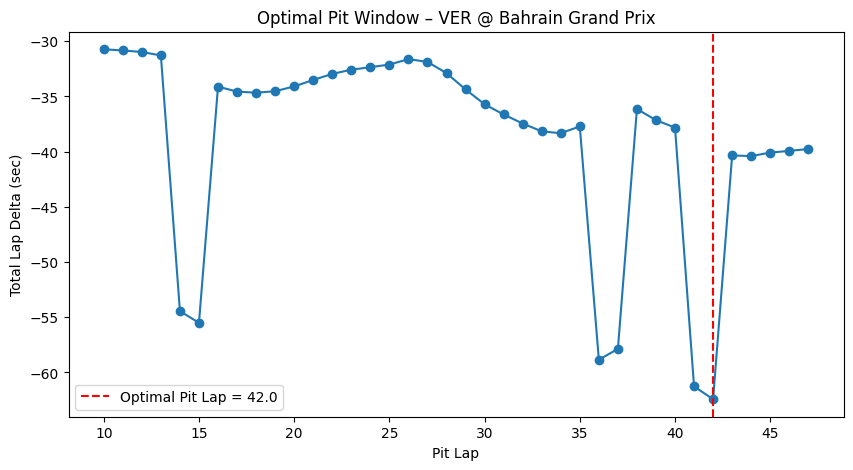

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(
    results_df["PitLap"],
    results_df["TotalLapDelta"],
    marker="o"
)
plt.axvline(
    optimal["PitLap"],
    color="red",
    linestyle="--",
    label=f"Optimal Pit Lap = {optimal['PitLap']}"
)
plt.xlabel("Pit Lap")
plt.ylabel("Total Lap Delta (sec)")
plt.title(f"Optimal Pit Window – {driver} @ {race}")
plt.legend()
plt.show()
